<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/hypertune_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

---



In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle


In [ ]:
! pip install bravado

In [8]:
#! time conda install -c conda-forge -y mordred bravado molvs
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [9]:
! wget https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df.csv

--2021-04-02 18:40:59--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549989 (537K) [text/plain]
Saving to: ‘curated_combined_df.csv’

curated_combined_df 100%[===================>] 537.10K  --.-KB/s    in 0.05s   

2021-04-02 18:40:59 (10.7 MB/s) - ‘curated_combined_df.csv’ saved [549989/549989]



In [10]:
import pandas as pd
df = pd.read_csv('curated_combined_df.csv', index_col=0)
df

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL599233,CC(C(=O)c1cccc([N+](=O)[O-])c1)N1CCCCC1,5.000000,0,5.000000,0.000000,0.000000,0
1,CHEMBL2047573,OC(CCN1CCC(O)(Cc2ccccc2)CC1)c1ccc(Cl)c(Cl)c1,6.248721,1,6.249574,0.000738,0.013645,0
2,CHEMBL1083410,CNC[C@H](O)CCN1c2ccccc2N(c2ccccc2F)S1(=O)=O,5.618163,0,5.619388,0.001060,0.021791,0
3,CHEMBL3673162,COc1ccc(-c2ccc3c(c2)CN2CCC3(c3ccc(Cl)c(Cl)c3)C...,8.229148,1,8.229574,0.000602,0.005177,0
4,CHEMBL2096860,COC(=O)[C@H]1C2CCC(C[C@@H]1c1ccc(I)cc1)N2C,7.643974,1,7.642648,0.002293,0.017351,0
...,...,...,...,...,...,...,...,...
8276,CHEMBL3143431,CC[C@H](C)[C@H](NC(=O)[C@@H](NC[C@H](CC(C)C)NC...,8.100000,1,8.100000,NaN,0.000000,0
8277,CHEMBL411570,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,3.740000,0,3.740000,NaN,0.000000,0
8278,CHEMBL1200633,CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@...,5.450000,1,5.450000,NaN,0.000000,0
8279,CHEMBL383931,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...,3.760000,0,3.760000,NaN,0.000000,0


In [11]:
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
3720,CHEMBL100010,COC(=O)C1C(c2ccccc2)=CC2CCC1C2,5.420000,1,5.420000,NaN,0.000000,0
422,CHEMBL100010,COC(=O)C1=C(c2ccccc2)CC2CCC1C2,5.418392,0,5.419196,0.001137,0.014840,0
5161,CHEMBL103152,COC(=O)C1C(c2ccc3ccccc3c2)=CC2CCC1C2,7.960000,1,7.960000,NaN,0.000000,0
638,CHEMBL103152,COC(=O)C1=C(c2ccc3ccccc3c2)CC2CCC1C2,7.958607,1,7.959304,0.000985,0.008749,0
7581,CHEMBL1062,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CC[C@...,5.260000,1,5.260000,NaN,0.000000,0
...,...,...,...,...,...,...,...,...
6,CHEMBL88915,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,8.928180,1,8.929090,0.001287,0.010189,0
410,CHEMBL89469,COC(=O)C1=C(c2ccc(F)cc2)CC2CCC1N2C,6.389340,1,6.389670,0.000467,0.005166,0
4442,CHEMBL89469,COC(=O)C1C(c2ccc(F)cc2)=CC2CCC1N2C,6.390000,1,6.390000,NaN,0.000000,0
3526,CHEMBL89662,COC(=O)C1C(c2ccccc2)=CC2CCC1N2C,5.590000,1,5.590000,NaN,0.000000,0


In [12]:
df_grouped = df.groupby('compound_id', as_index=False)['VALUE_NUM_mean'].mean()
df_grouped

,compound_id,VALUE_NUM_mean
0,10015831,6.642070
1,10048368,7.550060
2,10073022,7.740060
3,10084648,5.827500
4,10090352,8.221850
...,...,...
5471,CHEMBL98279,8.100000
5472,CHEMBL98645,6.270000
5473,CHEMBL99038,8.210000
5474,CHEMBL99354,7.840000


In [13]:
df_dedup = df.drop_duplicates('compound_id')
df_avg = df_dedup.merge(df_grouped, left_on='compound_id', right_on='compound_id')


In [ ]:
df_avg.drop('VALUE_NUM_mean_x', axis=1, inplace=True)
df_avg.rename(columns={'VALUE_NUM_mean_y': 'VALUE_NUM_mean'}, inplace=True)
df_avg

In [15]:
df_avg.to_csv('curated_combined_df_1.csv')

In [65]:
df_avg

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,VALUE_NUM_mean
0,CHEMBL599233,CC(C(=O)c1cccc([N+](=O)[O-])c1)N1CCCCC1,5.000000,0,0.000000,0.000000,0,5.000000
1,CHEMBL2047573,OC(CCN1CCC(O)(Cc2ccccc2)CC1)c1ccc(Cl)c(Cl)c1,6.248721,1,0.000738,0.013645,0,6.249574
2,CHEMBL1083410,CNC[C@H](O)CCN1c2ccccc2N(c2ccccc2F)S1(=O)=O,5.618163,0,0.001060,0.021791,0,5.619388
3,CHEMBL3673162,COc1ccc(-c2ccc3c(c2)CN2CCC3(c3ccc(Cl)c(Cl)c3)C...,8.229148,1,0.000602,0.005177,0,8.229574
4,CHEMBL2096860,COC(=O)[C@H]1C2CCC(C[C@@H]1c1ccc(I)cc1)N2C,7.643974,1,0.002293,0.017351,0,7.642648
...,...,...,...,...,...,...,...,...
5471,CHEMBL218952,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,3.700000,0,NaN,0.000000,0,3.700000
5472,CHEMBL3143431,CC[C@H](C)[C@H](NC(=O)[C@@H](NC[C@H](CC(C)C)NC...,8.100000,1,NaN,0.000000,0,8.100000
5473,CHEMBL411570,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,3.740000,0,NaN,0.000000,0,3.740000
5474,CHEMBL383931,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...,3.760000,0,NaN,0.000000,0,3.760000


# Split

---



In [22]:
working_dir = '/content'

In [23]:
# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['VALUE_NUM_mean']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = "curated_combined_df_1.csv"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_stategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-02 18:49:57,468 ['split_stategy'] are not part of the accepted list of parameters and will be ignored
2021-04-02 18:50:29,066 Splitting data by scaffold


number of features: 1024


2021-04-02 18:50:32,835 Dataset split table saved to /curated_combined_df_1_train_valid_test_scaffold_ccaf2954-1960-407c-99e5-ba585f87945e.csv


In [26]:
listing = glob.glob(os.path.join("/", "curated_combined_df_1_train_valid_test_scaffold_*"))

# Train Initial Rf

---



In [27]:
# train inital rf model

name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [28]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-02 18:55:36,427 Previous dataset split restored


n_cnt [5476.]
y_means [6.7145083]
y_stds [1.20144795]
TIMING: dataset construction took 0.217 s
Loading dataset from disk.
TIMING: dataset construction took 0.033 s
Loading dataset from disk.
TIMING: dataset construction took 0.033 s
Loading dataset from disk.


2021-04-02 18:55:48,166 Wrote model metadata to file ampl_output/curated_combined_df_1/RF_ecfp_scaffold_regression/7acbc8b2-ccaf-467a-939a-8b2445838d45/model_metadata.json
2021-04-02 18:55:49,817 Wrote model metrics to file ampl_output/curated_combined_df_1/RF_ecfp_scaffold_regression/7acbc8b2-ccaf-467a-939a-8b2445838d45/model_metrics.json


Wrote model tarball to ampl_output/curated_combined_df_1_model_7acbc8b2-ccaf-467a-939a-8b2445838d45.tar.gz


In [29]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.468


In [31]:
pred_data = pl.model_wrapper.get_perf_data(subset="full", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['r2_score']:.3f}")

R2 score of test set: -30.003


In [27]:
# Adding uncertainty to base training model
# The glob module finds all the pathnames matching a specified pattern according to the rules
listing = glob.glob(os.path.join("/", "curated_combined_df_1_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [28]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-02 01:11:29,589 Previous dataset split restored


n_cnt [5476.]
y_means [6.7145083]
y_stds [1.20144795]
TIMING: dataset construction took 0.195 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.


2021-04-02 01:11:40,569 Wrote model metadata to file ampl_output/curated_combined_df_1/RF_ecfp_scaffold_regression/27fcbbb3-1796-494a-9d99-92798c300094/model_metadata.json
2021-04-02 01:11:42,177 Wrote model metrics to file ampl_output/curated_combined_df_1/RF_ecfp_scaffold_regression/27fcbbb3-1796-494a-9d99-92798c300094/model_metrics.json


Wrote model tarball to ampl_output/curated_combined_df_1_model_27fcbbb3-1796-494a-9d99-92798c300094.tar.gz


In [29]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.474


# Grid Search 1

In [ ]:
n_estimator = [100,200,300,400,500]
rf_max_depth = [8,25,70,150,250]
rf_max_features = [10,25,30,50,100]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

In [31]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
9,100,25,100,0.486695
22,100,250,30,0.485362
99,400,250,100,0.483535
117,500,150,30,0.482380
44,200,150,100,0.481651
...,...,...,...,...
50,300,8,10,0.211522
25,200,8,10,0.211000
75,400,8,10,0.206582
100,500,8,10,0.206418


In [35]:
perf_df[ (perf_df.valid_r2_score <0.5) & (perf_df.valid_r2_score>0.48)] # definitely increase rf_max_depth, rf_max_features

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
9,100,25,100,0.486695
16,100,150,25,0.481570
22,100,250,30,0.485362
44,200,150,100,0.481651
63,300,70,50,0.480755
99,400,250,100,0.483535
117,500,150,30,0.482380
124,500,250,100,0.480084


In [43]:
perf_df[(perf_df.rf_estimators==100)].sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
9,100,25,100,0.486695
22,100,250,30,0.485362
16,100,150,25,0.481570
7,100,25,30,0.479673
13,100,70,50,0.478050
21,100,250,25,0.474921
14,100,70,100,0.474647
19,100,150,100,0.474202
24,100,250,100,0.473873
8,100,25,50,0.473614


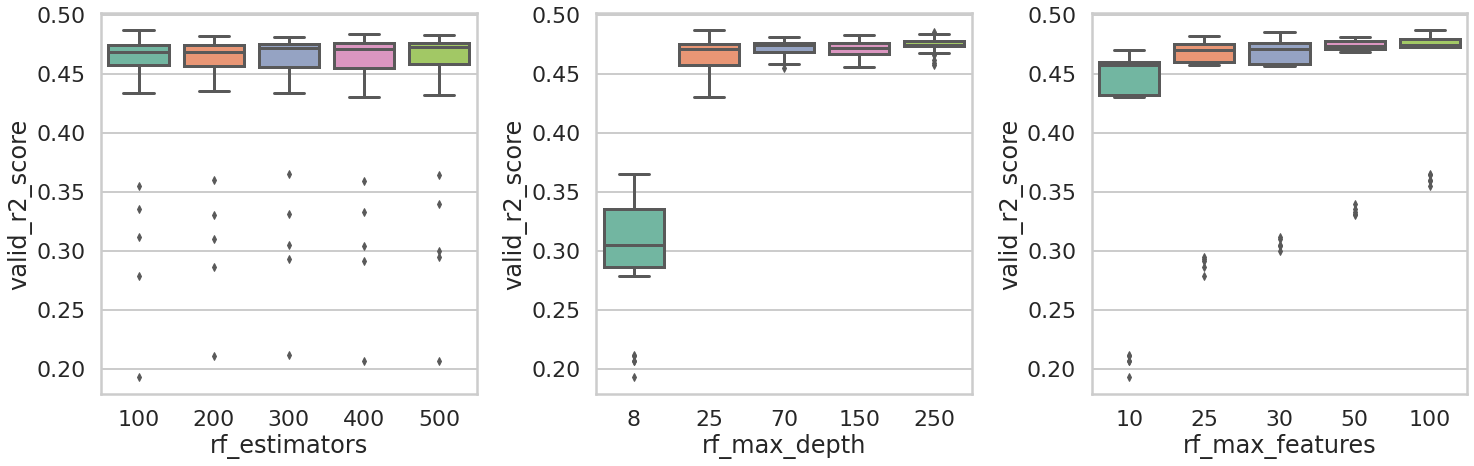

In [36]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

# Refined Grid Search

In [ ]:
n_estimator = [100]
rf_max_depth = [70,75,80,90,100,125,150,175,250,200,275,300]
rf_max_features = [30,35,40,45,50,60,65,70,80,90,100,120,150,200]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

In [52]:
perf_df2 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df2.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
79,100,125,90,0.485353
38,100,80,100,0.484969
10,100,70,100,0.484795
115,100,250,45,0.483610
105,100,175,70,0.483529
...,...,...,...,...
103,100,175,60,0.456631
155,100,300,35,0.456566
45,100,90,45,0.456440
60,100,100,50,0.451440


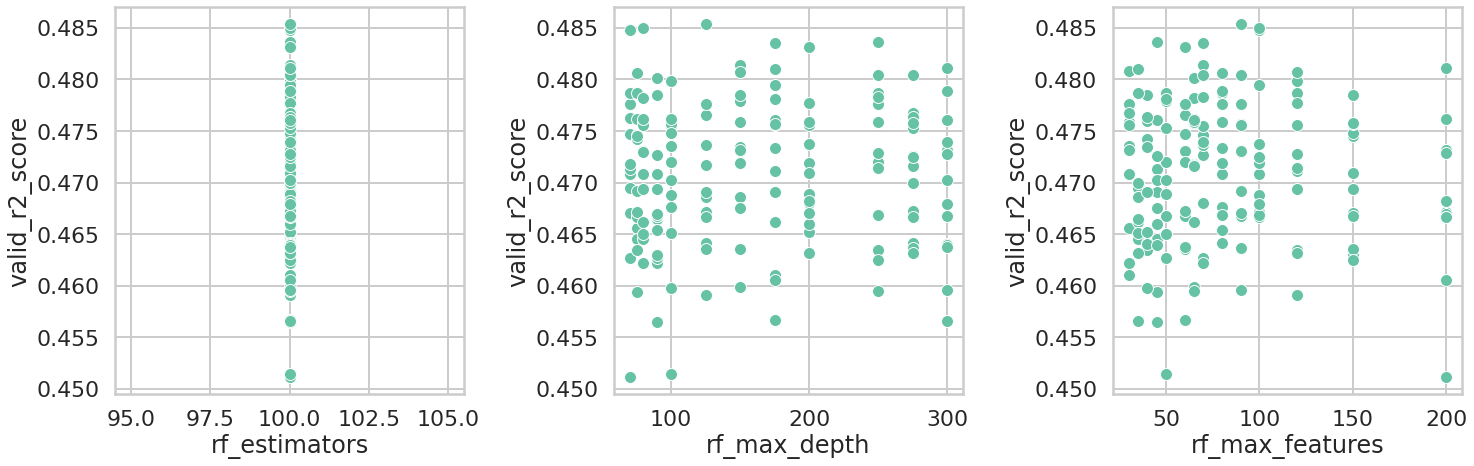

In [53]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df2, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df2, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df2, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

In [ ]:
n_estimator = [100]
rf_max_depth = [10,15,20,25,30,35,40,50]
rf_max_features = [90]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

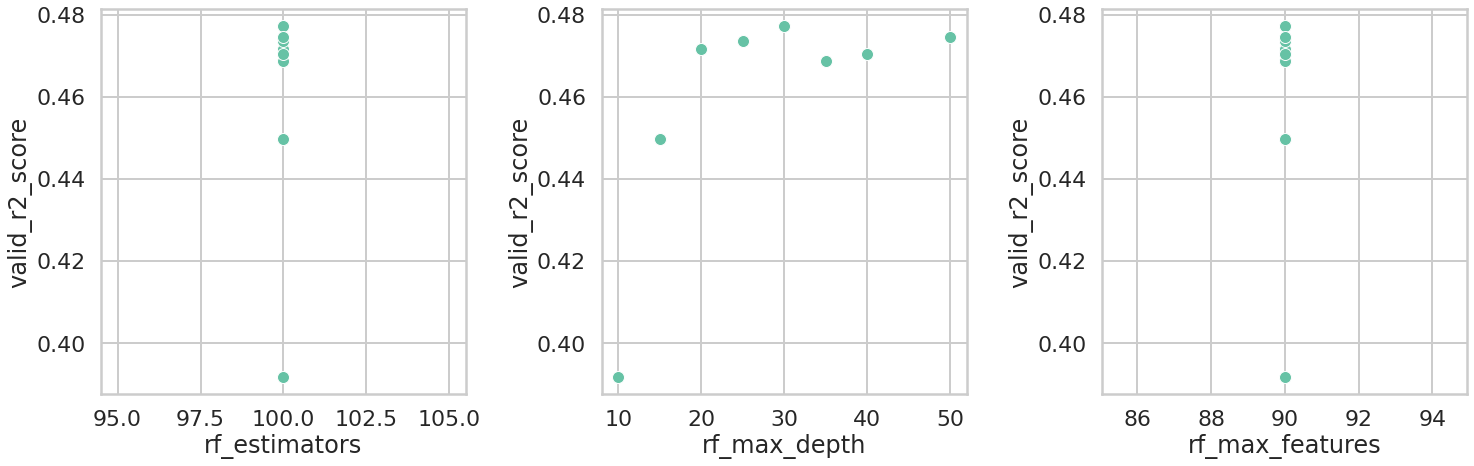

In [55]:
perf_df3 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df3.sort_values(by="valid_r2_score", ascending=False)
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df3, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df3, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df3, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

In [56]:
perf_df3

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
0,100,10,90,0.391777
1,100,15,90,0.449720
2,100,20,90,0.471734
3,100,25,90,0.473584
4,100,30,90,0.477136
5,100,35,90,0.468768
6,100,40,90,0.470354
7,100,50,90,0.474603


In [ ]:
n_estimator = [100]
rf_max_depth = [25,30]
rf_max_features = [100,150]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)

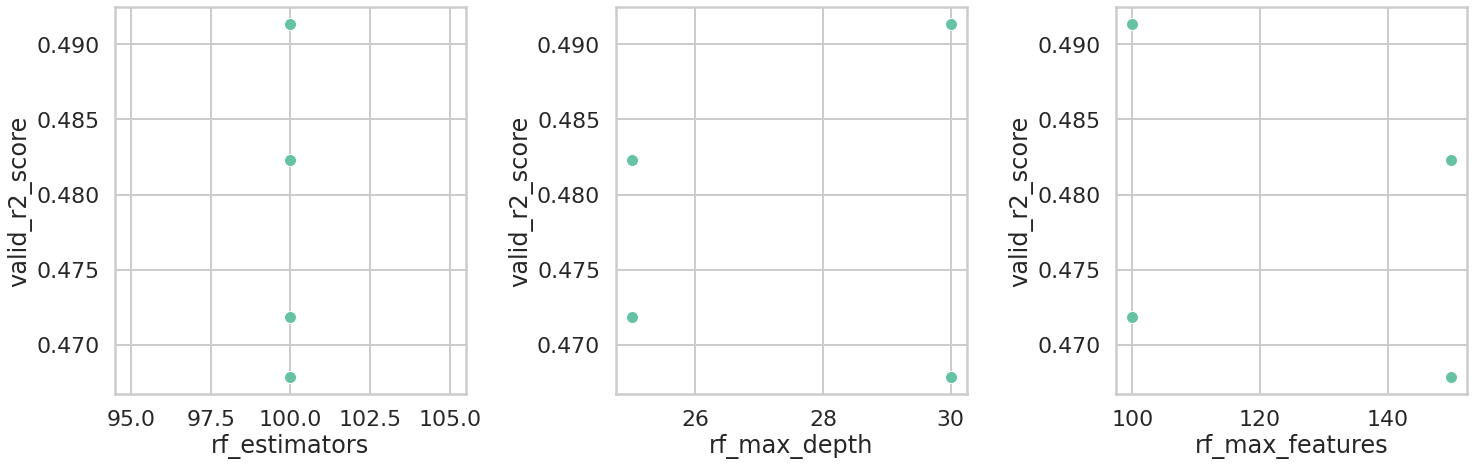

In [58]:
perf_df4 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df4.sort_values(by="valid_r2_score", ascending=False)
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df4, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df4, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df4, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

In [59]:
perf_df4 #100, 30,   >90 or 100/150

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
0,100,25,100,0.471863
1,100,25,150,0.482286
2,100,30,100,0.491330
3,100,30,150,0.467882


In [ ]:
n_estimator = [100]
rf_max_depth = [30]
rf_max_features = [105,110,115,120,125,130]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)

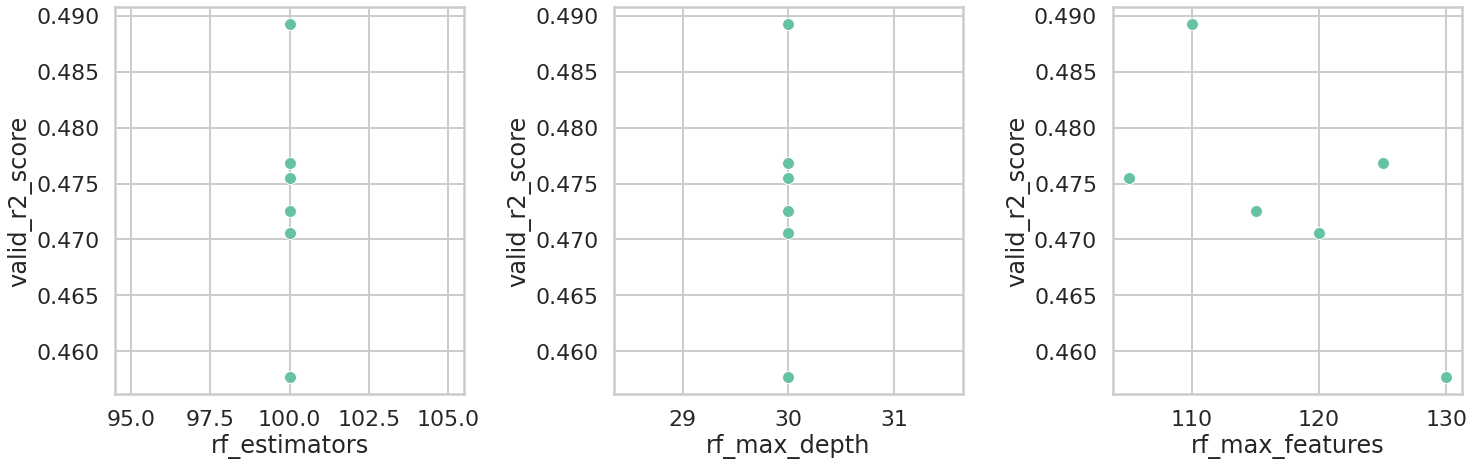

In [61]:
perf_df5 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df5.sort_values(by="valid_r2_score", ascending=False)
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df5, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df5, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df5, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

In [62]:
perf_df5

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
0,100,30,105,0.475473
1,100,30,110,0.489248
2,100,30,115,0.472540
3,100,30,120,0.470603
4,100,30,125,0.476872
5,100,30,130,0.457731


In [ ]:
n_estimator = [100,105,110,115,120]
rf_max_depth = [30]
rf_max_features = [91,92,93,94,95,96,97,98,99,100,101,102,103,104]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)

In [33]:
perf_df6 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df6.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
56,120,30,91,0.489437
6,100,30,97,0.486773
8,100,30,99,0.486446
20,105,30,97,0.485820
18,105,30,95,0.485262
...,...,...,...,...
35,110,30,98,0.463657
42,115,30,91,0.463645
26,105,30,103,0.463590
61,120,30,96,0.459903


In [ ]:
n_estimator = [300,600,800,900,1000,1200]
rf_max_depth = [30]
rf_max_features = [10,20,30,50,90]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)

In [43]:
perf_df7 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df7.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
3,300,30,50,0.482353
14,800,30,90,0.481779
24,1000,30,90,0.479413
29,1200,30,90,0.478008
9,600,30,90,0.477681
13,800,30,50,0.477407
23,1000,30,50,0.477313
4,300,30,90,0.477142
19,900,30,90,0.476791
18,900,30,50,0.476219


In [44]:
#  Retrieve model metadata and performance metrics stored in the filesystem from a hyperparameter search run.
cmp.get_filesystem_perf_results('ampl_output', pred_type='regression').sort_values(by='valid_r2_score', ascending=False)

Found data for 110 models under ampl_output


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
29,a450a840-73b9-4581-857c-9ab2568bab7c,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,120,91,30.0,0.489437,0.909945,0.361221,0.254297,4380,0.489437,0.855465,0.661167,548,0.388887,0.842471,0.679628,548
42,4cfefa08-1a0a-4952-856e-37d4f281e770,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,100,97,30.0,0.486773,0.910017,0.361076,0.254295,4380,0.486773,0.857695,0.658559,548,0.360030,0.862132,0.693836,548
73,2d0393b1-8325-4de8-a817-35266f5d20f0,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,100,99,30.0,0.486446,0.910606,0.359892,0.253076,4380,0.486446,0.857968,0.664167,548,0.364755,0.858943,0.693525,548
12,867f7524-c3bc-4e5e-8481-1007adc43fa7,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,105,97,30.0,0.485820,0.909912,0.361287,0.254555,4380,0.485820,0.858490,0.663387,548,0.358013,0.863489,0.696205,548
35,d3d12641-1c0c-4fcf-8387-6169062cc664,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,105,95,30.0,0.485262,0.909953,0.361204,0.254547,4380,0.485262,0.858956,0.668160,548,0.354012,0.866176,0.702013,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,88b87edd-bf10-40b9-b6ef-c757bd5fd849,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,900,10,30.0,0.448239,0.865149,0.442023,0.333708,4380,0.448239,0.889310,0.700557,548,0.311344,0.894324,0.727384,548
100,6837f6ce-c474-4c0d-a225-422b6d0c5095,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,800,10,30.0,0.447378,0.864562,0.442985,0.334724,4380,0.447378,0.890004,0.701765,548,0.310126,0.895115,0.727749,548
82,0146e174-ba39-4c0f-8a01-e304d3802ee6,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,1000,10,30.0,0.447116,0.863833,0.444175,0.335174,4380,0.447116,0.890215,0.702825,548,0.313161,0.893144,0.726086,548
5,cb98ccb7-b3d9-4ba6-954b-5dbb234e0e38,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,600,10,30.0,0.446594,0.865496,0.441455,0.333436,4380,0.446594,0.890635,0.702780,548,0.310283,0.895013,0.728996,548


In [59]:
# save the best model
cmp.copy_best_filesystem_models(pred_type="regression", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)


Found data for 110 models under ampl_output
Copied curated_combined_df_1_model_a450a840-73b9-4581-857c-9ab2568bab7c.tar.gz


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
29,a450a840-73b9-4581-857c-9ab2568bab7c,RF,curated_combined_df_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,120,91,30.0,0.489437,0.909945,0.361221,0.254297,4380,0.489437,0.855465,0.661167,548,0.388887,0.842471,0.679628,548


# Test??

---



---




In [ ]:
! pip install molvs

In [63]:
from atomsci.ddm.pipeline import predict_from_model

In [67]:
# Test loading model from tarball and running predictions
predict_from_model.predict_from_model_file(model_path='curated_combined_df_1_model_a450a840-73b9-4581-857c-9ab2568bab7c.tar.gz',
                            input_df = df_avg,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='VALUE_NUM_mean',
                            is_featurized=False,
                            dont_standardize=True)

2021-04-02 23:57:00,550 ['time_generated', 'time_built', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.281 s
Loading dataset from disk.


,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,VALUE_NUM_mean_std
1889,10015831,COC(=O)C1CN(C)CCC1c1ccc(Cl)cc1,6.642070,6.897717,0.307018
4273,10048368,COC(=O)[C@H]1[C@@H](c2ccc(I)cc2)C[C@@H]2CC[C@H...,7.550060,8.176506,0.268056
5195,10073022,Fc1ccc(C(OC2C[C@@H]3CC[C@H](C2)N3CCCCc2ccccc2)...,7.740060,7.689215,0.157957
2095,10084648,Cc1ccc(Sc2ccccc2CN(C)C)c(N)c1,5.827500,5.768296,0.218681
2005,10090352,Clc1ccc(-c2c3ccccc3c3n2CCN3)cc1,8.221850,6.522228,0.734738
...,...,...,...,...,...
5365,CHEMBL98279,CN1C2CCC1[C@@H](C(=O)OCCc1ccc(N)cc1)[C@@H](OC(...,8.100000,8.053230,0.458863
5370,CHEMBL98645,CN1C2CCC1[C@@H](C(=O)OCCc1ccc(N=C=S)cc1)[C@@H]...,6.270000,6.754337,0.866180
5315,CHEMBL99038,CC(C)OC(=O)[C@@H]1C2CCC(C[C@@H]1OC(c1ccc(F)cc1...,8.210000,7.753867,0.306624
5078,CHEMBL99354,CN1C2CCC1C(C(=O)OCCc1ccc(N=[N+]=[N-])c(I)c1)C(...,7.840000,8.032337,0.399199


# random search

In [ ]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 10

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(100,500)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(100,1000)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)

    pl = mp.ModelPipeline(tp)
    pl.train_model()

    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    #print(f"rf_estimators: {rf_estimators}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

In [41]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
7,342,147,190,0.476130
4,306,24,339,0.463050
6,966,97,512,0.462236
9,973,232,715,0.457537
3,881,149,661,0.456527
2,848,153,708,0.454724
0,222,47,675,0.449138
1,419,227,886,0.445084
8,545,147,978,0.441447
5,755,9,377,0.385238


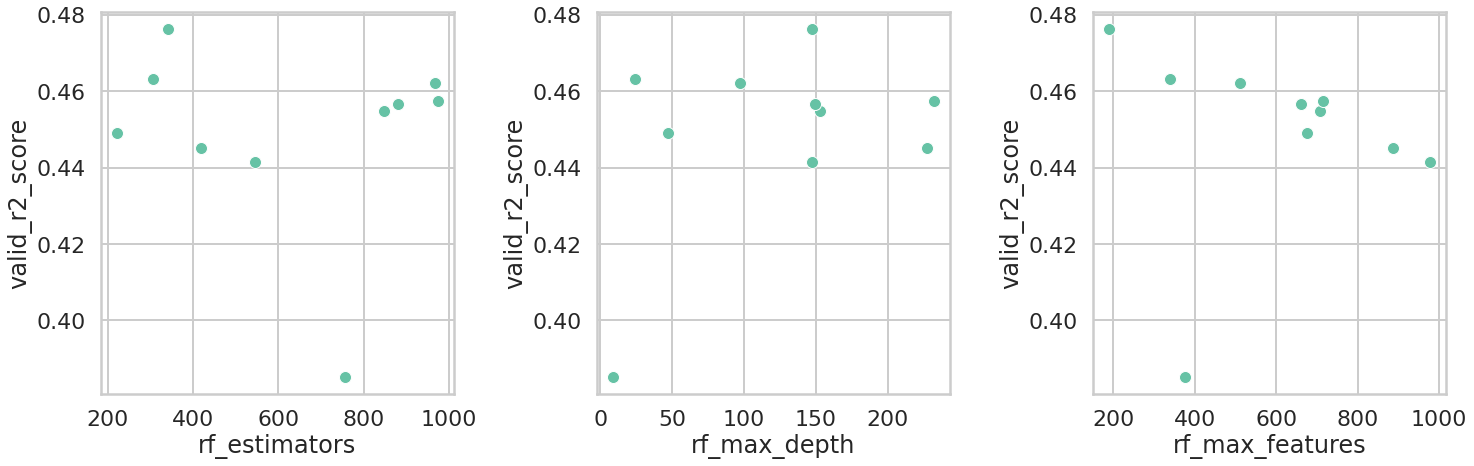

In [42]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()